In [18]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

## Permutation Feature Importance
The feature importances were not the same across the three methods. For Boosted Decision Tree, DPD had the highest importance value of 9.9, with the remaining three variables having importance values of 0.18 or less. For Decision Tree Regression and Linear Regression, both have ADP as the most important feature. However, the value of ADP for Decision Tree was 10.1 (with the remaining 3 variables scoring 0.16 or lower), but the value for ADP for Linear Regression was 4.6 (with MWD coming in second with 0.55 and the remaining variables scoring 0.08 or lower).

## Methods Description
1. In the paper, the authors call this method permutation importance (or the single-pass permutation importance to be more specific). It works by permuting the values of a single feature and measuring the expected model quality. If the expected model quality does not change or the change is very small, the feature is considered unimportant. This will repeat with one feature at a time.
2. One model-agnostic method is called the SHapley Additive exPlanations (SHAP), which is a Shapley-based method. It computes the contribution of each feature to the model output by calculating the diferrence in output when a feature (x1) is included in a feature subset (e.g. x1,x2,x3,x4) vs. when it is not (e.g. x2,x3,x4). This difference is calculated for all possible feature subsets. This ensures fairness because it takes into account feature interactions. SHAP is a local explainability method because it is computed for a single example so it answers the question "Why did the model make a certain prediction for a specific set of examples?"
3. Single-pass or grouped permutation importance: permutation_importance from scikit-learn\
SHapley Additive exPlanations (SHAP): shap.Explainer from SHAP package\
Accumulated Local Effects (ALE): ale.explain from alibi package\
Partial Dependence (PD): PartialDependenceDisplay from scikit-learn\
Local Interpretable Model-agnostic Explanations (LIME): LimeTabularExplainer from lime package\
Tree Interpreter: predict from treeinterpreter package


## Preparing the EPA AQS Data

In [29]:
df = pd.read_csv('LA_AQS_2023.csv')

In [4]:
df_O3 = df[(df['Parameter Name']=='Ozone') & (df['Duration Description']=='1 HOUR')]
df_O3 = pd.DataFrame(data = {"O3" : df_O3["Arithmetic Mean"], 'date' : df_O3["Date (Local)"]})
df_O3

,O3,date
20,0.031708,2023-01-01
64,0.015792,2023-01-02
204,0.025000,2023-01-03
228,0.020500,2023-01-04
271,0.027375,2023-01-05
...,...,...
21122,0.020750,2023-09-26
21168,0.020700,2023-09-27
21218,0.035056,2023-09-28
21261,0.039048,2023-09-29


In [5]:
df_NO2 = df[(df['Parameter Name']=='Nitrogen dioxide (NO2)') & (df['Duration Description']=='1 HOUR')]
df_NO2 = pd.DataFrame(data = {"NO2" : df_NO2["Arithmetic Mean"], 'date' : df_NO2["Date (Local)"]})
df_NO2

,NO2,date
1,4.816667,2023-01-01
19,4.550000,2023-01-01
29,4.550000,2023-01-01
41,4.816667,2023-01-01
44,14.720833,2023-01-02
...,...,...
21264,8.614286,2023-09-29
21297,6.370833,2023-09-30
21298,6.370833,2023-09-30
21307,7.362500,2023-09-30


In [6]:
df_PM = df[(df['Parameter Name']=='PM2.5 - Local Conditions') & (df['Duration Description']=='1 HOUR')]
df_PM = pd.DataFrame(data = {"PM" : df_PM["Arithmetic Mean"], 'date' : df_PM["Date (Local)"]})
df_PM

,PM,date
30,5.087500,2023-01-01
73,9.187500,2023-01-02
92,4.312500,2023-01-03
237,4.266667,2023-01-04
280,6.704167,2023-01-05
...,...,...
21109,14.225000,2023-09-26
21139,12.829167,2023-09-27
21203,13.883333,2023-09-28
21246,10.875000,2023-09-29


In [7]:
df_all = df_NO2.merge(df_O3, on=['date'])
df_all

,NO2,date,O3
0,4.816667,2023-01-01,0.031708
1,4.550000,2023-01-01,0.031708
2,4.550000,2023-01-01,0.031708
3,4.816667,2023-01-01,0.031708
4,14.720833,2023-01-02,0.015792
...,...,...,...
1087,8.614286,2023-09-29,0.039048
1088,6.370833,2023-09-30,0.030042
1089,6.370833,2023-09-30,0.030042
1090,7.362500,2023-09-30,0.030042


In [8]:
df_all = df_all.merge(df_PM, on=['date'])
df_all

,NO2,date,O3,PM
0,4.816667,2023-01-01,0.031708,5.087500
1,4.550000,2023-01-01,0.031708,5.087500
2,4.550000,2023-01-01,0.031708,5.087500
3,4.816667,2023-01-01,0.031708,5.087500
4,14.720833,2023-01-02,0.015792,9.187500
...,...,...,...,...
1079,8.614286,2023-09-29,0.039048,10.875000
1080,6.370833,2023-09-30,0.030042,6.416667
1081,6.370833,2023-09-30,0.030042,6.416667
1082,7.362500,2023-09-30,0.030042,6.416667


In [9]:
months = pd.DatetimeIndex(df_all['date']).month.values # without the .values, it would spit out a nd64 index
months

array([1, 1, 1, ..., 9, 9, 9])

In [11]:
sIdx = months - months #Set values (including winter) to zero
sIdx[months == 6] = 1 #Set summer to 1
sIdx[months == 7] = 1
sIdx[months == 8] = 1

sIdx[months == 3] = -1 #Set spring to -1
sIdx[months == 4] = -1
sIdx[months == 5] = -1

sIdx[months == 9] = -1 #Set fall to -1
sIdx[months == 10] = -1
sIdx[months == 11] = -1

In [12]:
sIdx

array([ 0,  0,  0, ..., -1, -1, -1])

In [13]:
df_all['Season'] = sIdx
df_all.describe()

,NO2,O3,PM,Season
count,1084.000000,1084.000000,1084.000000,1084.000000
mean,13.306238,0.027882,11.936013,-0.103321
std,6.205608,0.007571,5.099546,0.878820
min,3.458333,0.008333,3.250000,-1.000000
25%,8.780952,0.023833,8.145833,-1.000000
50%,11.618750,0.028458,10.912500,0.000000
75%,16.641667,0.032958,15.154167,1.000000
max,33.466667,0.045750,31.979167,1.000000


In [14]:
df_all = df_all[df_all['Season'] > -1] # should keep only winter(0) and summer(1)
df_all.describe()

,NO2,O3,PM,Season
count,604.000000,604.000000,604.000000,604.000000
mean,14.908291,0.025534,11.883327,0.609272
std,6.819712,0.007501,4.928007,0.488318
min,4.250000,0.008333,3.250000,0.000000
25%,9.700000,0.022000,8.545833,0.000000
50%,13.425000,0.026417,10.900000,1.000000
75%,19.133333,0.031542,15.266667,1.000000
max,33.466667,0.042833,31.979167,1.000000


In [16]:
Xvar = df_all[['O3','NO2','PM']].to_numpy()
Xvar

array([[ 0.031708,  4.816667,  5.0875  ],
       [ 0.031708,  4.55    ,  5.0875  ],
       [ 0.031708,  4.55    ,  5.0875  ],
       ...,
       [ 0.025042, 18.208333, 19.341667],
       [ 0.025042, 20.458333, 19.341667],
       [ 0.025042, 20.458333, 19.341667]])

In [17]:
yvar = np.array(df_all['Season'])
yvar

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

## Permutation Feature Importance of EPA AQS Linear Classification

In [23]:
lc = LogisticRegression().fit(Xvar, yvar) # in the documentation, logistic regression is implemented as a linear model for classification
lc_result = permutation_importance(lc, Xvar, yvar, n_repeats=10, 
                                   scoring = 'neg_mean_squared_error', random_state=0)

features = ['03', 'NO2', 'PM']
data = {
    'Feature': features,
    'Mean': lc_result.importances_mean,
    'Std Dev' : lc_result.importances_std
}

lc_df = pd.DataFrame(data)

lc_df

,Feature,Mean,Std Dev
0,03,0.000000,0.000000
1,NO2,0.237583,0.017912
2,PM,0.188907,0.018052


Text(0.5, 1.0, 'Linear Classification of EPA AQS Data')

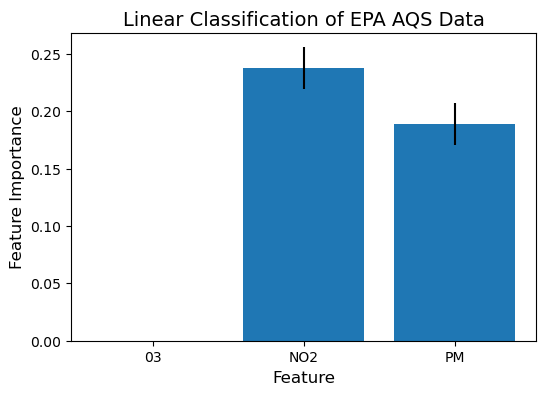

In [27]:
plt.figure(figsize=(6,4))

plt.bar(x='Feature', height='Mean', yerr='Std Dev', data=lc_df)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Feature Importance', fontsize=12)
plt.title('Linear Classification of EPA AQS Data', fontsize=14)

## Preparing the NOAA Buoy Data

In [30]:
df1 = pd.read_csv('Waves_2023.txt', sep='\s+') 
df1

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Thaomy\AppData\Local\Temp\ipykernel_53472\139389422.py:1: SyntaxWarning: invalid escape sequence '\s'
  df1 = pd.read_csv('Waves_2023.txt', sep='\s+')


,YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,2023,1,1,0,26,999,99.0,99.0,1.12,12.50,7.69,269,9999.0,999.0,15.3,999.0,99.0,99.0
1,2023,1,1,0,56,999,99.0,99.0,1.16,11.76,7.34,272,9999.0,999.0,15.3,999.0,99.0,99.0
2,2023,1,1,1,26,999,99.0,99.0,1.20,12.50,7.08,268,9999.0,999.0,15.3,999.0,99.0,99.0
3,2023,1,1,1,56,999,99.0,99.0,1.25,10.53,7.33,268,9999.0,999.0,15.4,999.0,99.0,99.0
4,2023,1,1,2,26,999,99.0,99.0,1.27,10.53,7.57,268,9999.0,999.0,15.5,999.0,99.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17280,2023,12,31,21,56,999,99.0,99.0,2.01,14.29,11.19,270,9999.0,999.0,16.7,999.0,99.0,99.0
17281,2023,12,31,22,26,999,99.0,99.0,1.75,15.38,10.37,267,9999.0,999.0,16.7,999.0,99.0,99.0
17282,2023,12,31,22,56,999,99.0,99.0,1.79,13.33,10.50,268,9999.0,999.0,16.8,999.0,99.0,99.0
17283,2023,12,31,23,26,999,99.0,99.0,1.66,14.29,10.32,271,9999.0,999.0,16.8,999.0,99.0,99.0


In [31]:
X = df1[['DPD','APD','MWD','WTMP']].to_numpy()
X

array([[ 12.5 ,   7.69, 269.  ,  15.3 ],
       [ 11.76,   7.34, 272.  ,  15.3 ],
       [ 12.5 ,   7.08, 268.  ,  15.3 ],
       ...,
       [ 13.33,  10.5 , 268.  ,  16.8 ],
       [ 14.29,  10.32, 271.  ,  16.8 ],
       [ 12.5 ,  10.54, 271.  ,  16.9 ]])

In [32]:
y = np.array(df1['WVHT'])
y

array([1.12, 1.16, 1.2 , ..., 1.79, 1.66, 1.7 ])

## Permutation Feature Importance of NOAA Buoy Predictions

In [33]:
boost = XGBRegressor(n_estimators=48, learning_rate=0.5).fit(X, y) 
boost_result = permutation_importance(boost, X, y, n_repeats=10, 
                                   scoring = 'neg_mean_squared_error', random_state=0)

features = ['DPD','APD','MWD','WTMP']
data = {
    'Feature': features,
    'Mean': boost_result.importances_mean,
    'Std Dev' : boost_result.importances_std
}

boost_df = pd.DataFrame(data)

boost_df

,Feature,Mean,Std Dev
0,DPD,9.887171,0.015097
1,APD,0.183745,0.003787
2,MWD,0.148583,0.002932
3,WTMP,0.145928,0.002824


Text(0.5, 1.0, 'Boosted Decision Tree of NOAA Buoy Data')

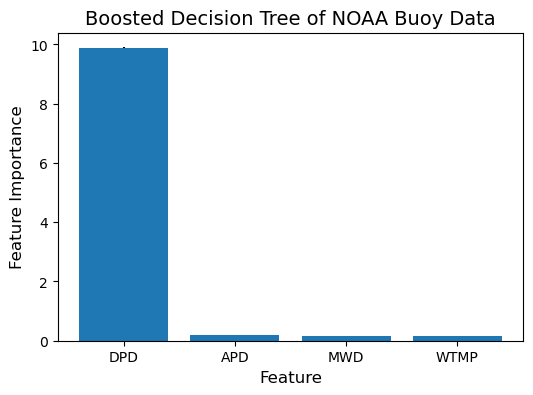

In [34]:
plt.figure(figsize=(6,4))

plt.bar(x='Feature', height='Mean', yerr='Std Dev', data=boost_df)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Feature Importance', fontsize=12)
plt.title('Boosted Decision Tree of NOAA Buoy Data', fontsize=14)

In [35]:
tree = DecisionTreeRegressor(max_depth=5).fit(X, y) 
tree_result = permutation_importance(tree, X, y, n_repeats=10, 
                                   scoring = 'neg_mean_squared_error', random_state=0)

features = ['DPD','APD','MWD','WTMP']
data = {
    'Feature': features,
    'Mean': tree_result.importances_mean,
    'Std Dev' : tree_result.importances_std
}

tree_df = pd.DataFrame(data)

tree_df

,Feature,Mean,Std Dev
0,DPD,0.168765,0.004270
1,APD,10.101780,0.012209
2,MWD,0.157331,0.002677
3,WTMP,0.040901,0.001669


Text(0.5, 1.0, 'Decision Tree Regression of NOAA Buoy Data')

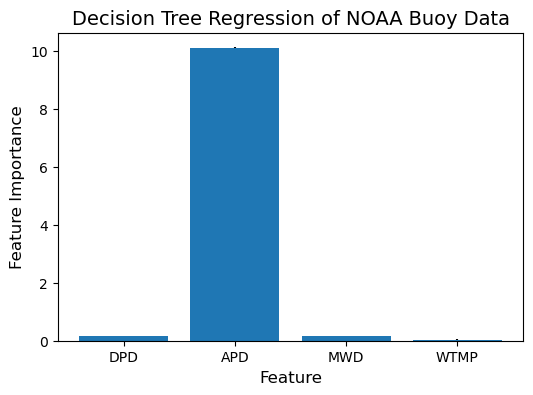

In [36]:
plt.figure(figsize=(6,4))

plt.bar(x='Feature', height='Mean', yerr='Std Dev', data=tree_df)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Feature Importance', fontsize=12)
plt.title('Decision Tree Regression of NOAA Buoy Data', fontsize=14)

In [37]:
lr = LinearRegression().fit(X, y) 
lr_result = permutation_importance(lr, X, y, n_repeats=10, 
                                   scoring = 'neg_mean_squared_error', random_state=0)

features = ['DPD','APD','MWD','WTMP']
data = {
    'Feature': features,
    'Mean': lr_result.importances_mean,
    'Std Dev' : lr_result.importances_std
}

lr_df = pd.DataFrame(data)

lr_df

,Feature,Mean,Std Dev
0,DPD,0.085491,0.002739
1,APD,4.608503,0.019771
2,MWD,0.550400,0.010166
3,WTMP,0.065965,0.002989


Text(0.5, 1.0, 'Linear Regression of NOAA Buoy Data')

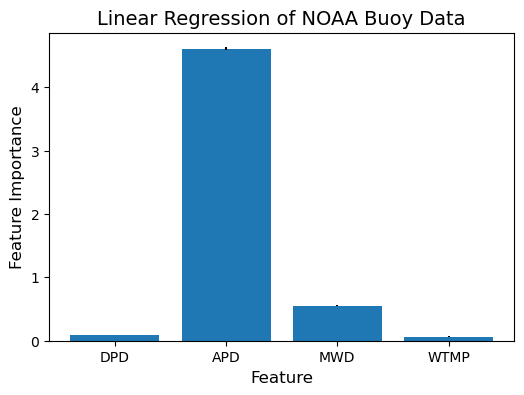

In [38]:
plt.figure(figsize=(6,4))

plt.bar(x='Feature', height='Mean', yerr='Std Dev', data=lr_df)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Feature Importance', fontsize=12)
plt.title('Linear Regression of NOAA Buoy Data', fontsize=14)